In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', family='Malgun Gothic')  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [7]:
# 데이터 준비
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# 평가 지표 계산 함수
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mspe = np.mean(np.square((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    medae = median_absolute_error(y_true, y_pred)
    medape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return [mse, rmse, mspe, mae, mape, medae, medape]

# 하이퍼파라미터 설정
look_back = 6 
batch_size = 32
epochs = 50
dropout_rate = 0.2

In [4]:
# 데이터 로드
df = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project_KTX\data\ktx_prep_v3.csv")

# 주운행선 매핑
line_mapping = {
    0: '경부선',
    1: '경전선',
    2: '동해선',
    3: '전라선',
    4: '호남선'
}

In [5]:
# 모델 정의
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model():
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:
# 모델 학습 및 평가
models = {'LSTM': build_lstm_model(), 'GRU': build_gru_model(), 'CNN-LSTM': build_cnn_lstm_model()}
results = []
all_preds = {}

for line_code in df['주운행선'].unique():
    df_line = df[df['주운행선'] == line_code]  # 라인별 데이터 추출

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_line['승차인원수'].values.reshape(-1, 1))

    X, y = create_dataset(scaled_data, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # 데이터 분리 (테스트 데이터는 마지막 12개월 고정)
    train_size = len(X) - 12
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    for name, model in models.items():
        print(f'Training {name} model for Line {line_mapping[line_code]}...')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
        y_pred = model.predict(X_test)

        # 역변환 및 평가
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler.inverse_transform(y_pred)

        # 평가 지표 계산
        metrics = calculate_metrics(y_test_inv, y_pred_inv)
        results.append([name, line_code] + metrics)

        # 예측값 저장
        if name not in all_preds:
            all_preds[name] = {}
        all_preds[name][line_code] = (
            df_line.iloc[-len(y_test):][['년도', '월']],  # 날짜 정보 저장
            y_test_inv,  # 실제값 저장
            y_pred_inv   # 예측값 저장
        )

# 결과 출력
columns = ['Model', 'Line', 'MSE', 'RMSE', 'MSPE', 'MAE', 'MAPE', 'MedAE', 'MedAPE']
results_df = pd.DataFrame(results, columns=columns)

# 매핑 적용
results_df['Line'] = results_df['Line'].map(line_mapping)
results_df

Training LSTM model for Line 경부선...
Epoch 1/50


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.4436 - val_loss: 0.5773
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3112 - val_loss: 0.4065
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2119 - val_loss: 0.2452
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1287 - val_loss: 0.1018
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0470 - val_loss: 0.0124
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0311 - val_loss: 0.0075
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0538 - val_loss: 0.0127
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0453 - val_loss: 0.0017
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0367 - val_loss: 0.0104
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0257 - val_loss: 0.0290
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0321 - val_loss: 0.0404
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0352 - val_loss: 0.0379
Epoch 13/50

,Model,Line,MSE,RMSE,MSPE,MAE,MAPE,MedAE,MedAPE
0,LSTM,경부선,8.766392e+10,296080.927301,0.710805,268995.416667,7.761924,207026.50000,6.283720
1,GRU,경부선,6.233392e+10,249667.619606,0.502313,216386.083333,6.226099,176239.25000,5.172327
2,CNN-LSTM,경부선,4.283368e+10,206962.987871,0.345069,176776.979167,5.086950,145061.75000,4.323743
3,LSTM,경전선,2.690845e+09,51873.352489,0.543024,44240.401042,6.348078,41669.00000,6.120916
4,GRU,경전선,2.052649e+09,45306.166059,0.413441,37539.416667,5.383182,32608.65625,4.768417
5,CNN-LSTM,경전선,1.093008e+09,33060.675371,0.226550,28956.015625,4.192832,34725.56250,5.148095
6,LSTM,전라선,2.428306e+09,49277.844486,0.408263,37564.520833,4.940389,27699.43750,3.750960
7,GRU,전라선,2.686406e+09,51830.553135,0.461484,43891.093750,5.829587,41041.90625,5.343930
8,CNN-LSTM,전라선,3.003702e+09,54806.043998,0.524188,46577.869792,6.174937,54881.50000,7.207437
9,LSTM,호남선,9.590686e+09,97932.046397,0.865843,85123.901042,8.175915,73785.65625,7.315740


In [9]:
# Best Model 선정
best_models = results_df.loc[results_df.groupby('Line')['RMSE'].idxmin()]
print("Best Models by Line:")
best_models

Best Models by Line:


,Model,Line,MSE,RMSE,MSPE,MAE,MAPE,MedAE,MedAPE
2,CNN-LSTM,경부선,4.283368e+10,206962.987871,0.345069,176776.979167,5.086950,145061.7500,4.323743
5,CNN-LSTM,경전선,1.093008e+09,33060.675371,0.226550,28956.015625,4.192832,34725.5625,5.148095
14,CNN-LSTM,동해선,9.148810e+08,30247.000322,0.287393,24136.312500,4.231376,23105.7500,3.947298
6,LSTM,전라선,2.428306e+09,49277.844486,0.408263,37564.520833,4.940389,27699.4375,3.750960
11,CNN-LSTM,호남선,3.746229e+09,61206.446141,0.348185,53112.515625,5.156657,52036.3125,5.134906


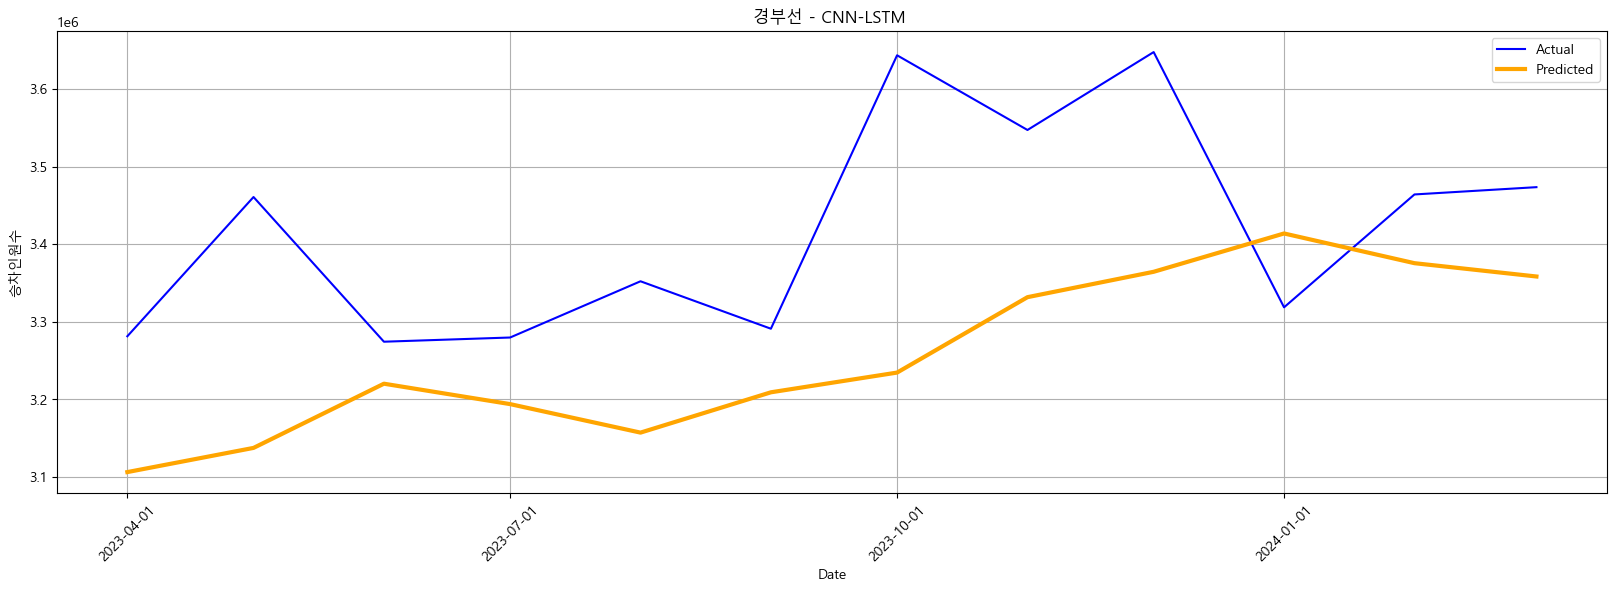

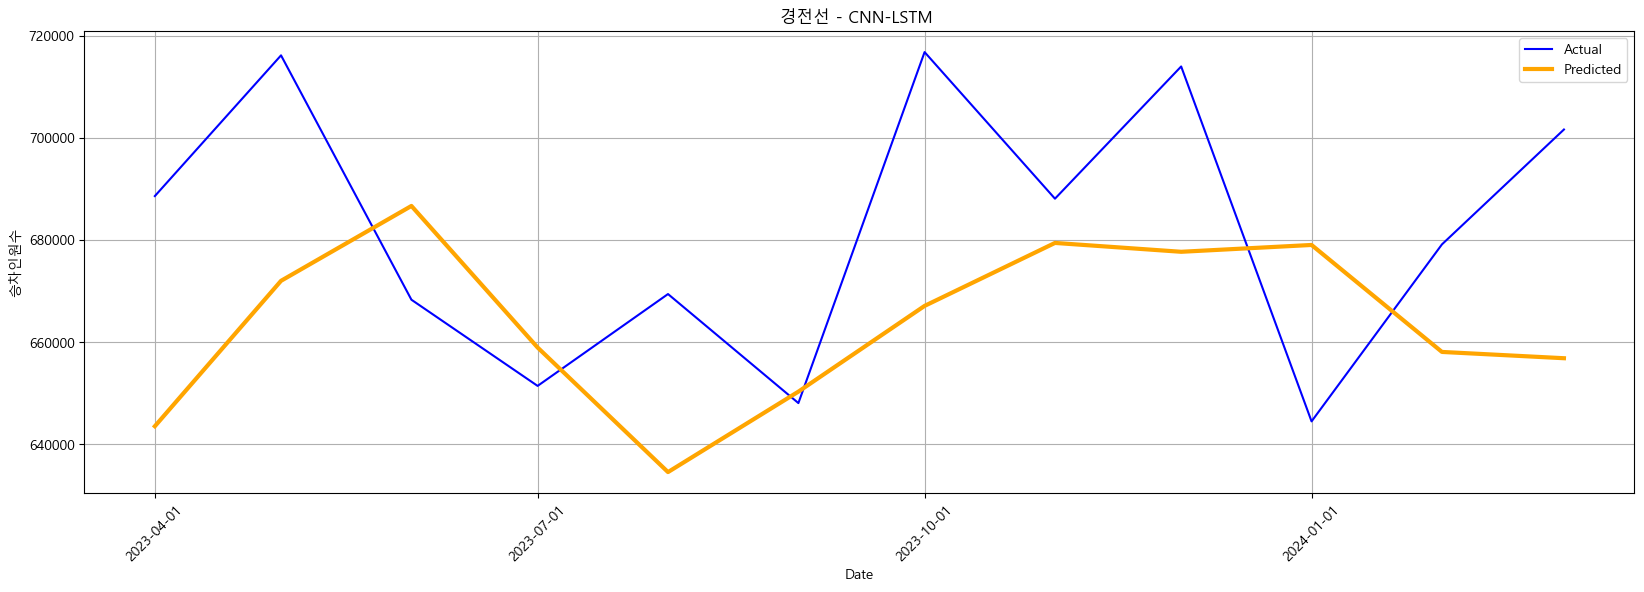

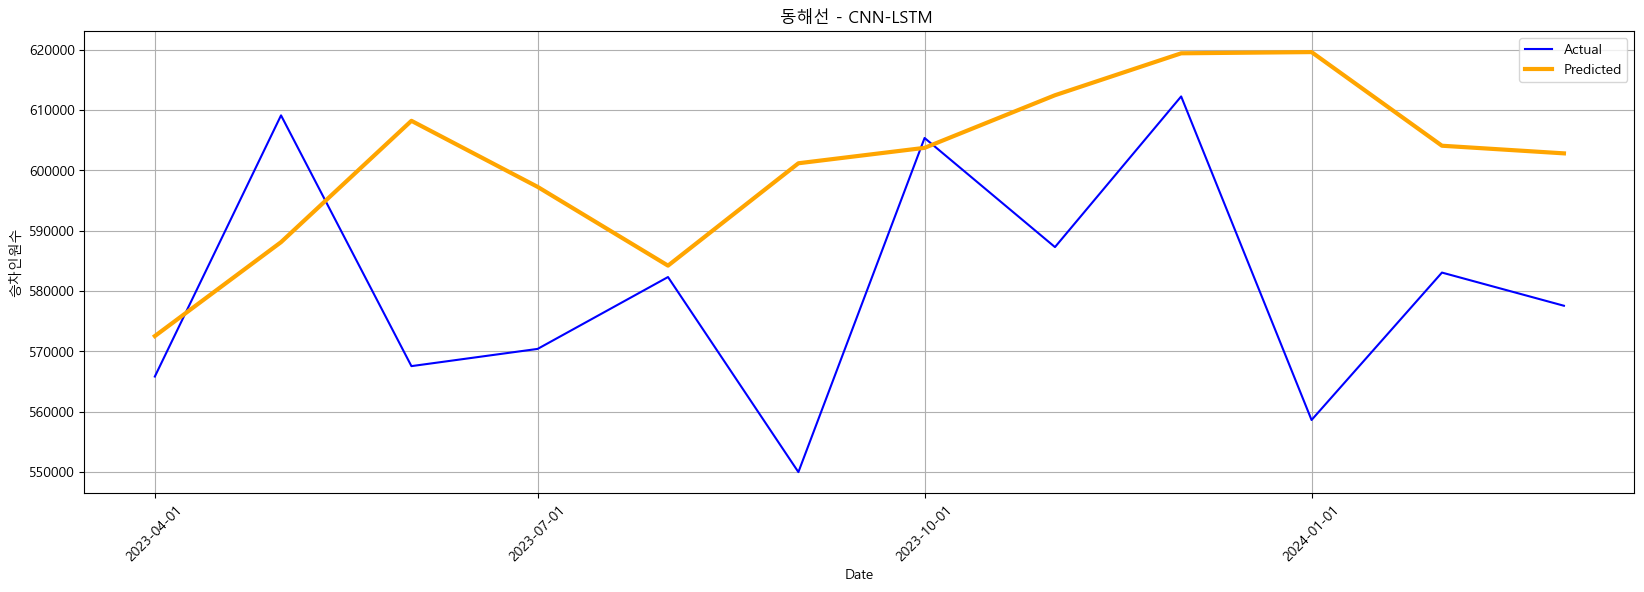

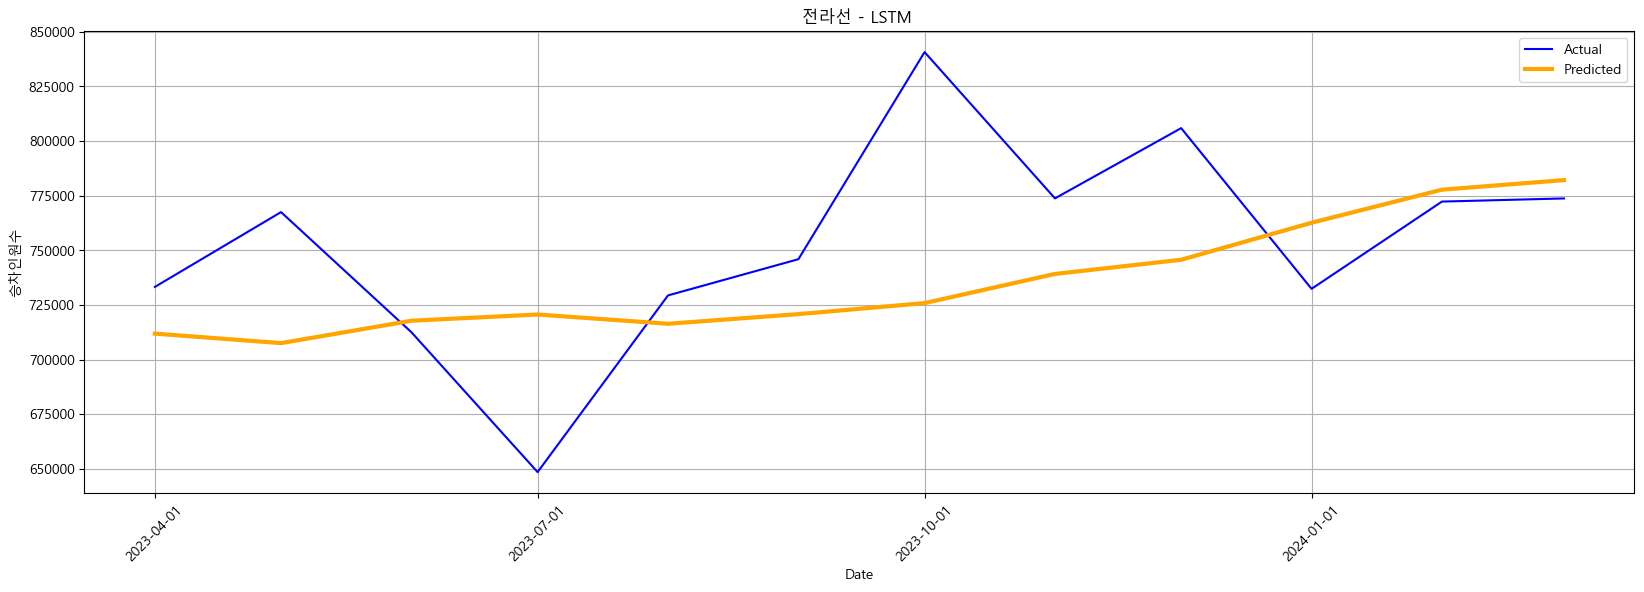

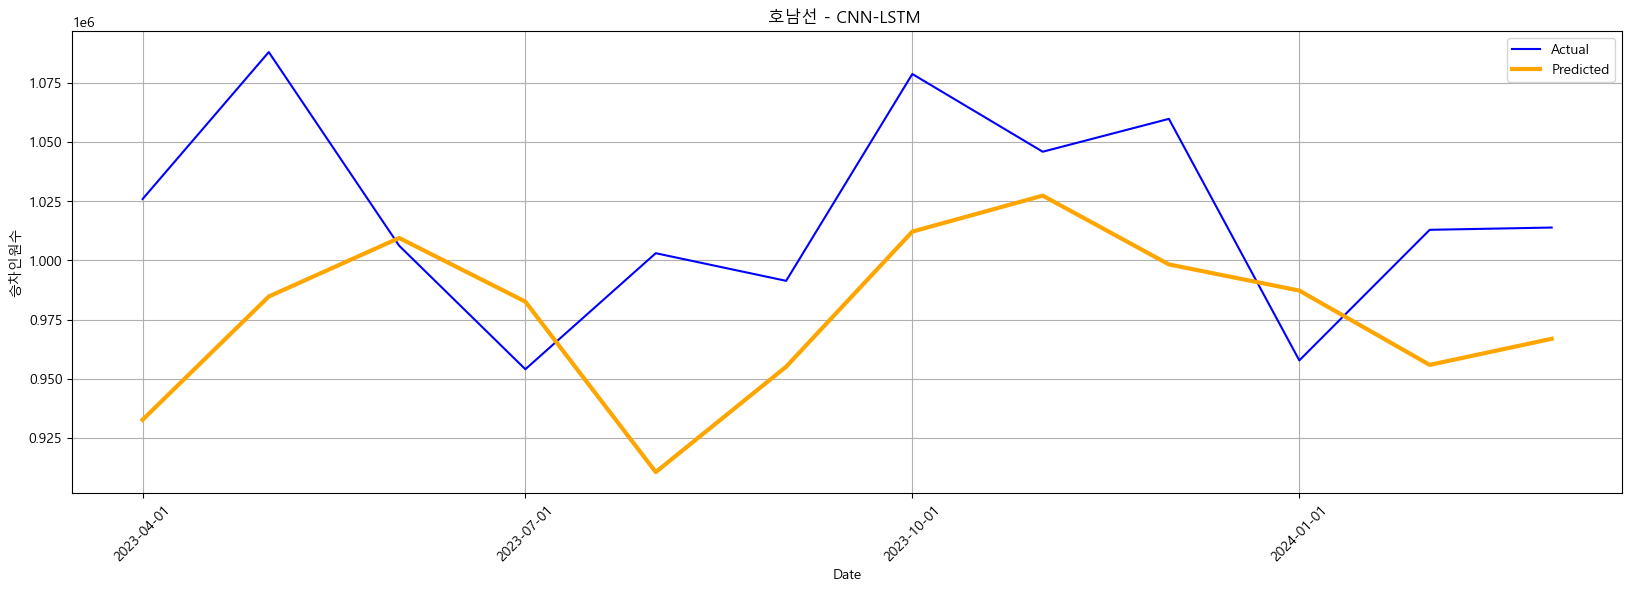

In [11]:
# 시각화
for index, row in best_models.iterrows():
    model_name = row['Model']
    line = row['Line']
    line_code = list(line_mapping.keys())[list(line_mapping.values()).index(line)]
    dates, y_test, y_pred = all_preds[model_name][line_code]

    # 시간 축 생성 및 정렬 
    dates = pd.to_datetime(dates['년도'].astype(str) + '-' + dates['월'].astype(str))
    dates = dates[-len(y_test):]  
    sorted_dates = dates.sort_values()
    y_test = y_test[np.argsort(dates)]
    y_pred = y_pred[np.argsort(dates)]

    plt.figure(figsize=(20, 6))
    plt.plot(sorted_dates, y_test, label='Actual', color='blue')
    plt.plot(sorted_dates, y_pred, label='Predicted', color='orange', linewidth=3)
    plt.title(f'{line} - {model_name} ')
    plt.xlabel('Date')
    plt.ylabel('승차인원수')
    plt.xticks(sorted_dates[::3], rotation=45)  # 3개월 단위 표시
    plt.legend()
    plt.grid(True)
    plt.show()